## DATA PROCESSING

Clean and prepare the 'transactions_data.csv' file from the Caixa Bank Real World Dataset

### Inspect initial rows

First I'll look at the first 5,000 rows from the 'transactions_data.csv' file
to see all of its column names, the data types, and any obvious issues

In [1]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path

#create variable for filepath
RAW = Path("../data/raw/caixa/transactions_data.csv")

#load first 5k rows and print first 5
top = pd.read_csv(RAW, nrows=5000)
top.head()


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [2]:
#get the data type for each attribute
top.dtypes

id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

### Create a data type map

This map makes pandas read these columns as string values. Having the 'amount' field in this form allows for removing unwanted characters, such as '€', from the fields later on

In [3]:
#create a map so that pandas reads these as string for speed and to avoid overflow warnings
dtype_map = {
        "card_id":    "string",
        "merchant_id":    "string",
        "use_chip":    "string",
        "amount":    "string",
        "zip":    "string"
    }

### Loop to clean data in sections (200,000 rows at a time)

For each section:
 - filter for card present transactions
 - remove rows with errors
 - remove all charatcers except decimals 1-9, decimal points, and minus signs
 - rename the date column to timestamp to be more clear
 - remove unecessary columns

Then combine all of the sections and write it to a new CSV file

In [4]:
dataset = pd.read_csv(RAW, dtype=dtype_map, chunksize=200000, parse_dates=["date"])
cleaned_ds = []
cols_to_keep = [
    "timestamp",
    "card_id",
    "merchant_id",
    "amount",
    "mcc",
    "merchant_city",
    "merchant_state",
    "zip"
]

#loop through each section
for chunk in dataset:
    #remove any card not present transactions (online or NaN) and copy the rest back to section
    chunk = chunk[chunk["use_chip"].str.contains("swipe", case=False, na=False)]

    #reformat the amount column to only contain the number, € or $
    chunk["amount"] = (
        #replace everything except the digits 0-9 and the characters '.' and '-', with nothing
        chunk["amount"].str.replace(r"[^\d.\-]", "", regex =True)
        #if doing so leaves the amount blank, make it NaN
        .replace("", np.nan)
        #make the amount a floating point number
        .astype("float32")
    )

    #drop any rows that still have no amount
    chunk.dropna(subset=["amount"], inplace=True)
    #drop any rows with an error
    chunk = chunk[ chunk["errors"].isna() ]
    #rename date column as timestamp
    chunk.rename(columns={"date": "timestamp"}, inplace=True)
    #connect all cleaned data into a dataset
    cleaned_ds.append(chunk[cols_to_keep])
#store the cleaned data as a dataframe and write it to a csv file
df = pd.concat(cleaned_ds, ignore_index=True)
#sort into chronological order
df.sort_values("timestamp", inplace=True)
#write to new file
df.to_csv("../data/processed/caixa_pos_sorted.csv", index=False)

#check to see how many rows were kept
print("rows kept:", len(df))
    

rows kept: 6863647


### Reload and check the new file

Reload the new CSV file to memory, sort by timestamp and merchant id so velocity stats can be checked later

Display the first few rows to ensure everything looks right

In [6]:
#reread the now sorted data to ensure it is correctly formatted
#parse the timestamp column as dates (otherwise read as strings)
df = pd.read_csv("../data/processed/caixa_pos_sorted.csv", parse_dates=["timestamp"])
#sort by merhcant id and time
df.sort_values(["merchant_id", "timestamp"], inplace=True)
df.head()


,timestamp,card_id,merchant_id,amount,mcc,merchant_city,merchant_state,zip
3131955,2012-10-14 16:48:00,4565,1,144.74,7922,Attleboro Falls,MA,2763.0
571866,2010-07-14 12:10:00,201,2,204.96,4900,Orlando,FL,32811.0
1382860,2011-04-06 17:07:00,3069,2,55.84,4900,Orlando,FL,32811.0
2299612,2012-01-25 08:14:00,190,3,21.27,5912,New Britain,CT,6051.0
1845986,2011-09-02 13:12:00,3846,5,6.81,5411,Pleasant Prairie,WI,53158.0


### Calculate the transaction velocity per merchant

All the timestamps in this dataset are rounded to the nearest minute, 60s  buckets are the smallest windows that can be used

Count unique card ids per merchant, per minute and look at the
distribution (mean, std dev, 90 / 95 / 99th percentiles)

In [7]:
#create 60s bucket columnn to see how many trtansactions take place every minute
df["bucket_60s"] = df["timestamp"].dt.floor("60s")
#group transactions by both merchant and card id to see how many different cards appear at merchant in bucket
vel = (df.groupby(["merchant_id","bucket_60s"])["card_id"].nunique())
#check mean, std dev., and 90,95,99 percentiles
vel.describe(percentiles=[.90,.95,.99])

count    6.692434e+06
mean     1.020404e+00
std      1.478453e-01
min      1.000000e+00
50%      1.000000e+00
90%      1.000000e+00
95%      1.000000e+00
99%      2.000000e+00
max      6.000000e+00
Name: card_id, dtype: float64

### Plot velocity distribution

Using a histogram shows that there are rarely more than two different cards used at the same merchant in one minute

This will be used as a baseline to compare to the Sparkov Dataset which is simulated and contains more velocity spikes

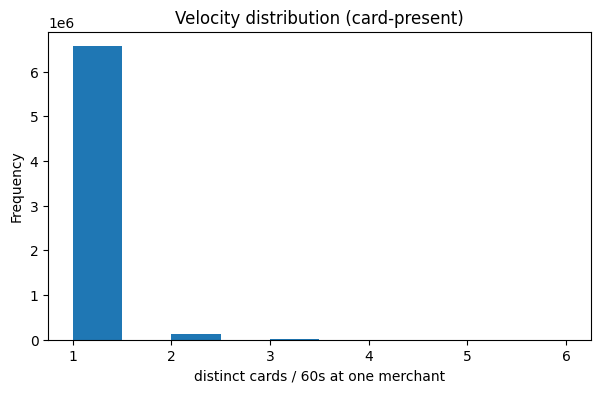

In [8]:
#draw histogram of velocity distribution
import matplotlib.pyplot as plt
vel.plot.hist(bins=10, figsize=(7,4))
plt.xlabel("distinct cards / 60s at one merchant")
plt.title("Velocity distribution (card-present)")
plt.show()

### What was learned

 - This CaixaBank swipe data showed that the 99 th percentile is ≤ 2 cards/minute
  and the maximum unique cards in a minute is 6  
 - This shows that natural velocity spikes are very rare in this
  real-world baseline
 - This makes this dataset good for false-positive testing